In [78]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import os
import re
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from get_tweets import get_tweets_by_search_term
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.max_columns", None)

In [79]:
# Import NLTK lexicon
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [80]:
# Fetch the Tweets
keywords = input("Enter keywords, hashtags separated by commas: ")
keywords = list(set(keywords.split(",")))
get_tweets_by_search_term(keywords)

,UserId,TweetId,tweet,location,created
0,Councillor Njohi,1508795864785035270,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","North Kinangop, Kenya",29-Mar-2022
1,Wanyama JK,1508795806232555526,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,Bungoma,29-Mar-2022
2,New Team Raila Odinga,1508795764843159566,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,,29-Mar-2022
3,Shantel,1508795752713228295,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,,29-Mar-2022
4,Kuilean,1508795692608860170,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!",,29-Mar-2022
...,...,...,...,...,...
4995,Francis kibor,1508488039215124489,@Jane_FKyalo That is how Ruto feels when you tell propaganda that he insulted Uhuru..Dunia ni du...,,28-Mar-2022
4996,Rakel,1508488036836913164,"Gaii these are the people Ruto looks to appoint as CSs,,,🤣🤣🤣 the international community find th...",KE,28-Mar-2022
4997,Benanzo,1508488003114708992,@makaumutua Ruto @WilliamsRuto should invest some of his money in a body language communications...,"London, England",28-Mar-2022
4998,Michael Oduor Otieno,1508487989487443968,@kipmurkomen @ahmednasirlaw @MarthaKarua @DavidNdii @JerotichSeii @WehliyeMohamed @makaumutua It...,"Nakuru, Kenya",28-Mar-2022


In [81]:
# Save tweets to pickle file and reload to DF - Avoid API calls
this_file_path = os.path.abspath("__file__")
BASE_DIR = os.path.dirname(this_file_path)
tweet_pickle_file = os.path.join(BASE_DIR, "tweets", "tweet_list.pkl")
tweets_df = pd.read_pickle(tweet_pickle_file)
tweets_df.head()


,UserId,TweetId,tweet,location,created
0,Councillor Njohi,1508795864785035270,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","North Kinangop, Kenya",29-Mar-2022
1,Wanyama JK,1508795806232555526,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,Bungoma,29-Mar-2022
2,New Team Raila Odinga,1508795764843159566,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,,29-Mar-2022
3,Shantel,1508795752713228295,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,,29-Mar-2022
4,Kuilean,1508795692608860170,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!",,29-Mar-2022


In [82]:
# Primary exploratory analysis
print('Dataset shape:', tweets_df.shape)
print('Dataset columns:', tweets_df.columns)
tweets_df.info()

Dataset shape: (5000, 5)
Dataset columns: Index(['UserId', 'TweetId', 'tweet', 'location', 'created'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UserId    5000 non-null   object
 1   TweetId   5000 non-null   int64 
 2   tweet     5000 non-null   object
 3   location  5000 non-null   object
 4   created   5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


In [83]:
# Drop all columns except for Tweet and create a list of all words
tweets_only_df = tweets_df.drop(['UserId', 'TweetId', 'location', 'created'], axis=1)
tweets_only_df.head()

,tweet
0,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves."
1,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...
2,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...
3,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...
4,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!"


In [84]:
# Remove http links from tweets
def remove_http_https(text):
    return re.sub(r'http\S+', '', text)

tweets_only_df['link_removed'] = tweets_only_df['tweet'].apply(lambda x: remove_http_https(x))
tweets_only_df.head()

,tweet,link_removed
0,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves."
1,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...
2,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...
3,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...
4,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!","@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!"


(-0.5, 399.5, 199.5, -0.5)

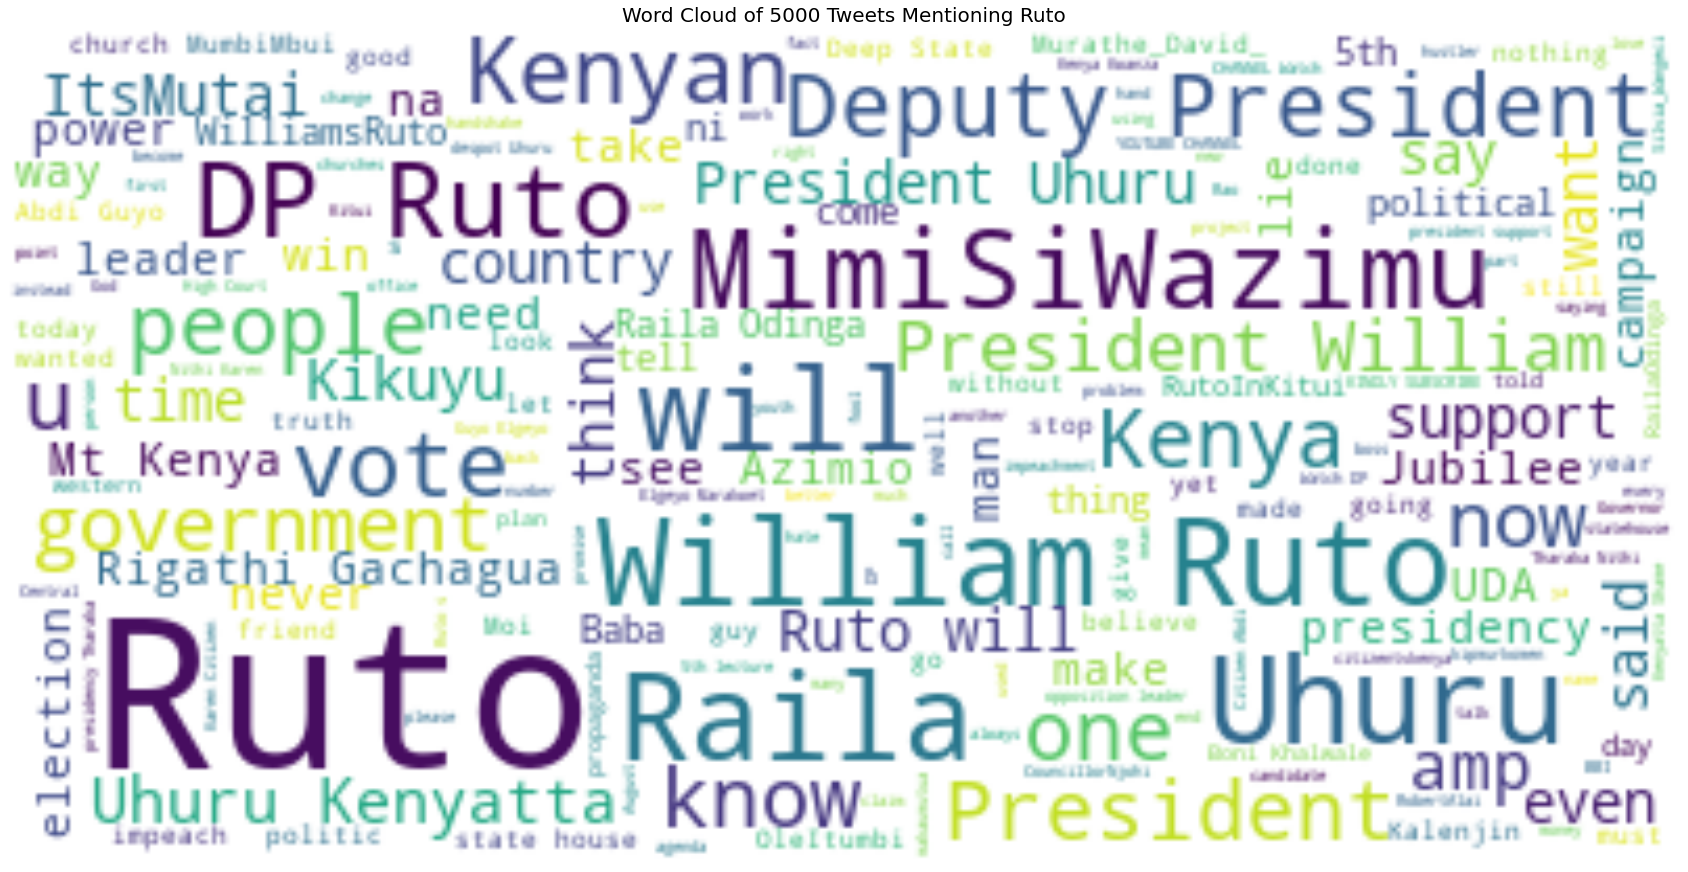

In [85]:
all_final_tweets = ' '.join(word for word in tweets_only_df['link_removed'])
fig, ax = plt.subplots(figsize=(30,30))
wordcloud_all_tweets = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(all_final_tweets)
ax.imshow(wordcloud_all_tweets, interpolation='bilinear')
ax.set_title('Word Cloud of 5000 Tweets Mentioning Ruto', fontsize=20)
ax.axis("off")

In [86]:
# Remove punctuations
#string.punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

tweets_only_df['tweet_punct'] = tweets_only_df['tweet'].apply(lambda x: remove_punct(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct
0,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.",Mr Ruto allowed Office of the Deputy President to be used to scam foreigners a den of thieves
1,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,MutahiNgunyi Which Raila has only Nyanza counties His former strong holds are now battle ground...
2,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto MimiSiWazimu where are the kimwarer Aror dam If you denied you ow...
3,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,Marende RailaOdinga MarthaKarua MusaliaMudavadi RCNATEMBEYA HonGachagua citizentvkenya Sirpelly ...
4,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!","@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!",Gmanreformer Richard NdunguWainaina When its UDA its Ruto


In [87]:
# Tokenize the tweets
def tokenize(text):
    text = re.split('\W+', text)
    return text

tweets_only_df['tweet_tokenized'] = tweets_only_df['tweet_punct'].apply(lambda x: tokenize(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized
0,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.",Mr Ruto allowed Office of the Deputy President to be used to scam foreigners a den of thieves,"[Mr, Ruto, allowed, Office, of, the, Deputy, President, to, be, used, to, scam, foreigners, a, d..."
1,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,MutahiNgunyi Which Raila has only Nyanza counties His former strong holds are now battle ground...,"[MutahiNgunyi, Which, Raila, has, only, Nyanza, counties, His, former, strong, holds, are, now, ..."
2,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto MimiSiWazimu where are the kimwarer Aror dam If you denied you ow...,"[Deputy, President, William, Ruto, MimiSiWazimu, where, are, the, kimwarer, Aror, dam, If, you, ..."
3,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,Marende RailaOdinga MarthaKarua MusaliaMudavadi RCNATEMBEYA HonGachagua citizentvkenya Sirpelly ...,"[Marende, RailaOdinga, MarthaKarua, MusaliaMudavadi, RCNATEMBEYA, HonGachagua, citizentvkenya, S..."
4,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!","@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!",Gmanreformer Richard NdunguWainaina When its UDA its Ruto,"[Gmanreformer, Richard, NdunguWainaina, When, its, UDA, its, Ruto]"


In [88]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

tweets_only_df['tweet_nonstop'] = tweets_only_df['tweet_tokenized'].apply(lambda x: remove_stopwords(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized,tweet_nonstop
0,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.",Mr Ruto allowed Office of the Deputy President to be used to scam foreigners a den of thieves,"[Mr, Ruto, allowed, Office, of, the, Deputy, President, to, be, used, to, scam, foreigners, a, d...","[Mr, Ruto, allowed, Office, Deputy, President, used, scam, foreigners, den, thieves]"
1,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,MutahiNgunyi Which Raila has only Nyanza counties His former strong holds are now battle ground...,"[MutahiNgunyi, Which, Raila, has, only, Nyanza, counties, His, former, strong, holds, are, now, ...","[MutahiNgunyi, Which, Raila, Nyanza, counties, His, former, strong, holds, battle, ground, half,..."
2,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto MimiSiWazimu where are the kimwarer Aror dam If you denied you ow...,"[Deputy, President, William, Ruto, MimiSiWazimu, where, are, the, kimwarer, Aror, dam, If, you, ...","[Deputy, President, William, Ruto, MimiSiWazimu, kimwarer, Aror, dam, If, denied, people, Rift, ..."
3,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,Marende RailaOdinga MarthaKarua MusaliaMudavadi RCNATEMBEYA HonGachagua citizentvkenya Sirpelly ...,"[Marende, RailaOdinga, MarthaKarua, MusaliaMudavadi, RCNATEMBEYA, HonGachagua, citizentvkenya, S...","[Marende, RailaOdinga, MarthaKarua, MusaliaMudavadi, RCNATEMBEYA, HonGachagua, citizentvkenya, S..."
4,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!","@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!",Gmanreformer Richard NdunguWainaina When its UDA its Ruto,"[Gmanreformer, Richard, NdunguWainaina, When, its, UDA, its, Ruto]","[Gmanreformer, Richard, NdunguWainaina, When, UDA, Ruto]"


In [89]:
# Stemming and lemmatization
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tweets_only_df['tweet_stemmed'] = tweets_only_df['tweet_nonstop'].apply(lambda x: stemming(x))

wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text
tweets_only_df['tweet_lemmatized'] = tweets_only_df['tweet_stemmed'].apply(lambda x: lemmatizer(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized
0,"Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.","Mr. Ruto allowed Office of the Deputy President to be used to scam foreigners, a den of thieves.",Mr Ruto allowed Office of the Deputy President to be used to scam foreigners a den of thieves,"[Mr, Ruto, allowed, Office, of, the, Deputy, President, to, be, used, to, scam, foreigners, a, d...","[Mr, Ruto, allowed, Office, Deputy, President, used, scam, foreigners, den, thieves]","[mr, ruto, allow, offic, deputi, presid, use, scam, foreign, den, thiev]","[mr, ruto, allow, offic, deputi, presid, use, scam, foreign, den, thiev]"
1,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,@MutahiNgunyi Which 44%. Raila has only Nyanza counties. His former strong holds are now battle ...,MutahiNgunyi Which Raila has only Nyanza counties His former strong holds are now battle ground...,"[MutahiNgunyi, Which, Raila, has, only, Nyanza, counties, His, former, strong, holds, are, now, ...","[MutahiNgunyi, Which, Raila, Nyanza, counties, His, former, strong, holds, battle, ground, half,...","[mutahingunyi, which, raila, nyanza, counti, hi, former, strong, hold, battl, ground, half, flip...","[mutahingunyi, which, raila, nyanza, counti, hi, former, strong, hold, battl, ground, half, flip..."
2,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto #MimiSiWazimu where are the kimwarer Aror dam ...If you denied yo...,Deputy President William Ruto MimiSiWazimu where are the kimwarer Aror dam If you denied you ow...,"[Deputy, President, William, Ruto, MimiSiWazimu, where, are, the, kimwarer, Aror, dam, If, you, ...","[Deputy, President, William, Ruto, MimiSiWazimu, kimwarer, Aror, dam, If, denied, people, Rift, ...","[deputi, presid, william, ruto, mimisiwazimu, kimwar, aror, dam, if, deni, peopl, rift, valley, ...","[deputi, presid, william, ruto, mimisiwazimu, kimwar, aror, dam, if, deni, peopl, rift, valley, ..."
3,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,@Marende2022 @RailaOdinga @MarthaKarua @MusaliaMudavadi @RC_NATEMBEYA @HonGachagua_ @citizentvke...,Marende RailaOdinga MarthaKarua MusaliaMudavadi RCNATEMBEYA HonGachagua citizentvkenya Sirpelly ...,"[Marende, RailaOdinga, MarthaKarua, MusaliaMudavadi, RCNATEMBEYA, HonGachagua, citizentvkenya, S...","[Marende, RailaOdinga, MarthaKarua, MusaliaMudavadi, RCNATEMBEYA, HonGachagua, citizentvkenya, S...","[marend, railaodinga, marthakarua, musaliamudavadi, rcnatembeya, hongachagua, citizentvkenya, si...","[marend, railaodinga, marthakarua, musaliamudavadi, rcnatembeya, hongachagua, citizentvkenya, si..."
4,"@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!","@Gmanreformer @Richard63707905 @NdunguWainaina When its UDA, its Ruto!",Gmanreformer Richard NdunguWainaina When its UDA its Ruto,"[Gmanreformer, Richard, NdunguWainaina, When, its, UDA, its, Ruto]","[Gmanreformer, Richard, NdunguWainaina, When, UDA, Ruto]","[gmanreform, richard, ndunguwainaina, when, uda, ruto]","[gmanreform, richard, ndunguwainaina, when, uda, ruto]"


(-0.5, 399.5, 199.5, -0.5)

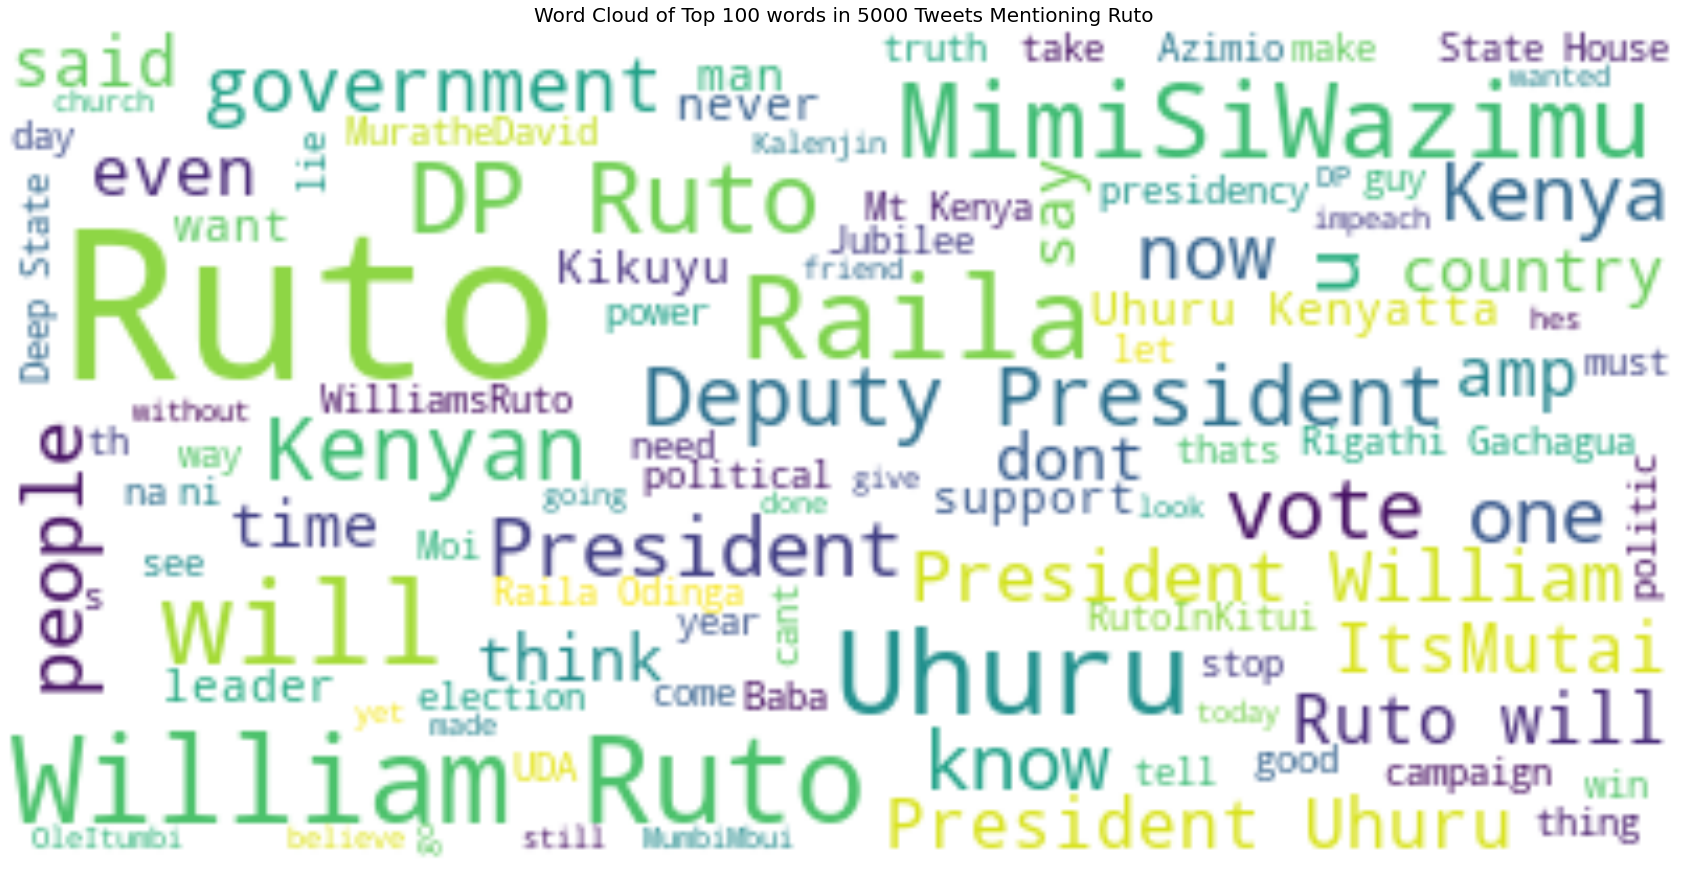

In [90]:
all_final_tweets = ' '.join(word for word in tweets_only_df['tweet_punct'])
fig, ax = plt.subplots(figsize=(30,30))
wordcloud_all_tweets = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_final_tweets)
ax.imshow(wordcloud_all_tweets, interpolation='bilinear')
ax.set_title('Word Cloud of Top 100 words in 5000 Tweets Mentioning Ruto', fontsize=20)
ax.axis("off")